# Importation des données

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, to_tree, cut_tree
from scipy.spatial.distance import pdist, squareform


from sklearn import metrics # for evaluations
from sklearn.datasets import make_blobs, make_circles # for generating experimental data
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [14]:
data = pd.read_csv("data/sample_100_4.csv")

# Clustering 

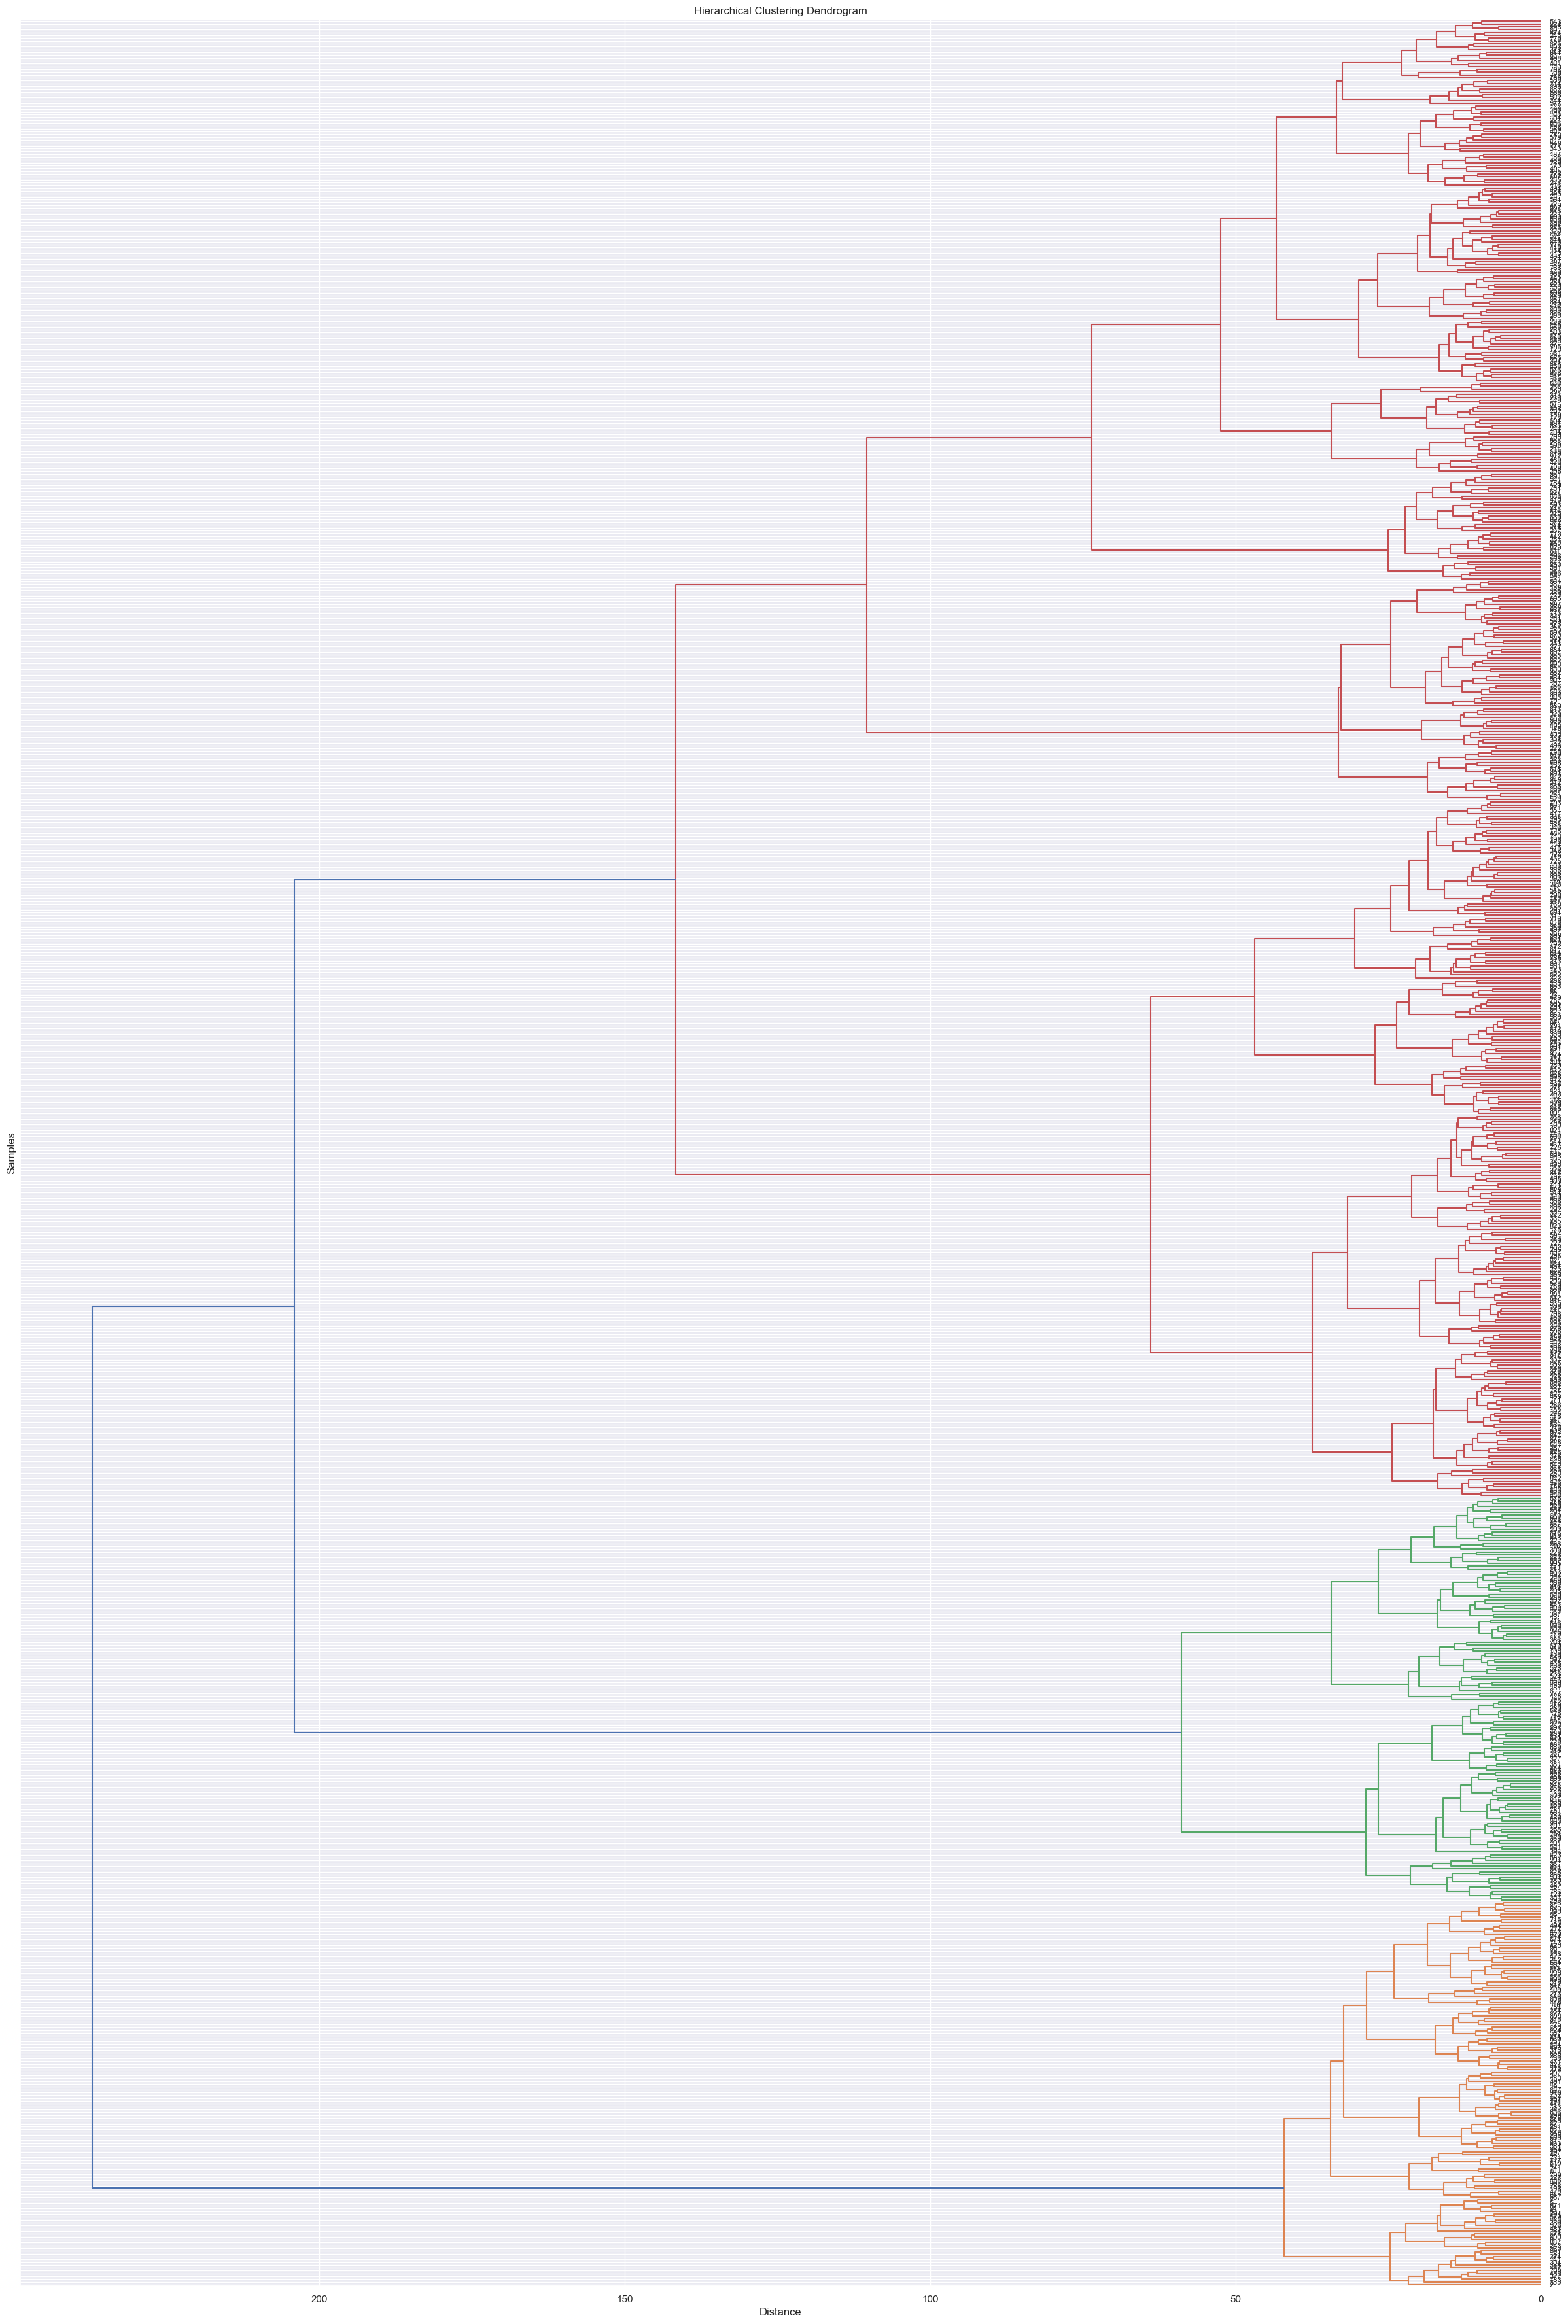

In [16]:
#On copie le DF :
data2 = data.drop(columns=['Unnamed: 0', 'Class'])

distance_matrix = squareform(pdist(data2, metric='euclidean'))

# Perform hierarchical clustering
linkage_matrix = linkage(data2, method='ward')

# Plot the dendrogram
plt.figure(figsize=(30, 45))
dendrogram(linkage_matrix,
           orientation="left",
           labels=data.index.tolist(),
           leaf_font_size=8)

plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Samples')
plt.xlabel('Distance')
plt.show()